In [ ]:
# generate plots as a function of clean signal amplitudes

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from PyPDF2 import PdfMerger
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join

2023-05-06 19:44:02.404876: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-06 19:44:02.412829: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 19:44:02.467620: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 19:44:02.468147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 19:44:03.108328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
wireplane = 'V'
path = '../processed_data/'

In [3]:
def load_data(path, wireplane):
    x_train = np.load(path+'x_train_' + wireplane + '.npy')
    x_test = np.load(path+'x_test_' + wireplane + '.npy')
    y_train = np.load(path+'y_train_AE_' + wireplane + '.npy')
    y_test = np.load(path+'y_test_AE_' + wireplane + '.npy')
    
    #split train and valid sets (40k train 10k valid) 
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train, y_train, test_size=0.2, shuffle=False
    )
    
    mean = x_train.mean()
    std = x_train.std()

    x_train_scaled = (x_train-mean)/std
    x_test_scaled = (x_test-mean)/std
    x_valid_scaled = (x_valid-mean)/std
    
    y_train_scaled = (y_train-mean)/std
    y_test_scaled = (y_test-mean)/std
    y_valid_scaled = (y_valid-mean)/std

    return x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_valid_scaled, y_valid_scaled, mean, std

In [4]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_valid_scaled, y_valid_scaled, mean, std = load_data(path, wireplane)

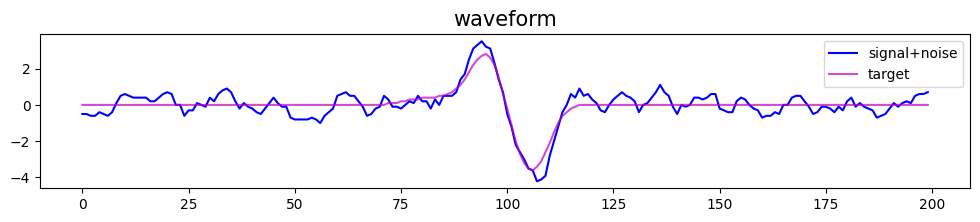

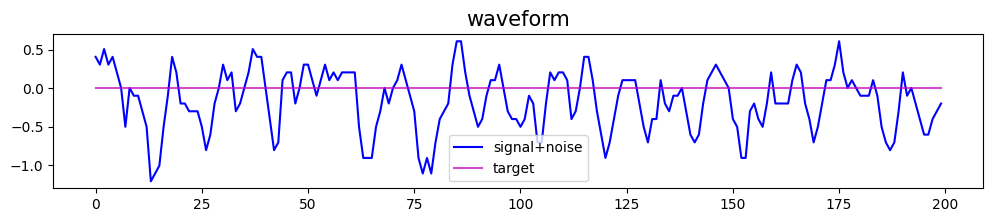

In [5]:
for idx in range(16,18):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_test_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_test_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [6]:
model = load_model('./models/model_AE_2048_no_pooling'+wireplane+'plane_nu.h5')

In [7]:
model.evaluate(x_train_scaled, y_train_scaled, batch_size=4096)
model.evaluate(x_valid_scaled, y_valid_scaled, batch_size=4096)
model.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

25/25 [==============================] - 1s 49ms/step - loss: 0.0108


0.010824654251337051

In [8]:
%%time
predictions = model.predict(x_test_scaled, batch_size=4096)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

25/25 [==============================] - 1s 49ms/step
CPU times: user 5.06 s, sys: 47.5 ms, total: 5.11 s
Wall time: 1.42 s


In [9]:
from scipy import stats
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_scaled*std + mean


pred = predictions*std + mean

In [10]:
#y_train_ = y_train_scaled*std + mean


Split testing set into subsets based on clean signal amplitudes

In [11]:
adc_3_5_x = []
adc_3_5_y = []
adc_3_5_p = []

adc_5_10_x = []
adc_5_10_y = []
adc_5_10_p = []

adc_10_15_x = []
adc_10_15_y = []
adc_10_15_p = []

adc_15_20_x = []
adc_15_20_y = []
adc_15_20_p = []

noise_x = []
noise_y = []
noise_p = []

adc_gt_20_x = []
adc_gt_20_y = []
adc_gt_20_p = []

for i, wave in enumerate(y_test_):
    if sum(abs(wave)) == 0:
        noise_y.append(wave)
        noise_p.append(pred[i])
        noise_x.append(x_test_[i])
        continue
    max_adc = max(abs(wave))
    if max_adc > 3 and max_adc <= 5:
        adc_3_5_y.append(wave)
        adc_3_5_p.append(pred[i])
        adc_3_5_x.append(x_test_[i])
    elif max_adc > 5 and max_adc <=10:
        adc_5_10_y.append(wave)
        adc_5_10_p.append(pred[i])
        adc_5_10_x.append(x_test_[i])
    elif max_adc > 10 and max_adc <= 15:
        adc_10_15_y.append(wave)
        adc_10_15_p.append(pred[i])
        adc_10_15_x.append(x_test_[i])
    elif max_adc > 15 and max_adc <= 20:
        adc_15_20_y.append(wave)
        adc_15_20_p.append(pred[i])
        adc_15_20_x.append(x_test_[i])
    else:
        adc_gt_20_y.append(wave)
        adc_gt_20_p.append(pred[i])
        adc_gt_20_x.append(x_test_[i])


In [12]:
print(len(noise_y), len(noise_p))

50000 50000


In [13]:
grouped_waves = [
            [adc_3_5_x, adc_3_5_y, adc_3_5_p], 
            [adc_5_10_x, adc_5_10_y, adc_5_10_p], 
            [adc_10_15_x, adc_10_15_y, adc_10_15_p],
            [adc_15_20_x, adc_15_20_y, adc_15_20_p],
            [adc_gt_20_x, adc_gt_20_y, adc_gt_20_p],
            [noise_x, noise_y, noise_p]
        ]

In [14]:
sum_ = 0
for i in grouped_waves:
    print(len(i[0]), len(i[1]), len(i[2]))
    sum_ += len(i[0])
print('sum: ', sum_)

3711 3711 3711
7488 7488 7488
3760 3760 3760
3832 3832 3832
31209 31209 31209
50000 50000 50000
sum:  100000


In [15]:
group_num_labels = {
                    0: 'adc_3_5',
                    1: 'adc_5_10',
                    2: 'adc_10_15',
                    3: 'adc_15_20',
                    4: 'adc_gt_20',
                    5: 'noise'
                    }

In [16]:
def make_single_pdf(wave_idx, pg_num, group_num):

    fig, axs = plt.subplots(3,2, figsize=(20, 12), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        wave_idx = index_


        axes[i].set_title('clean sig. +peak amplitude: ' + str(int(max(grouped_waves[group_num][1][index_]))),size=15)
        axes[i].plot(grouped_waves[group_num][0][index_], color='black', alpha=0.3, label='input')
        axes[i].plot(grouped_waves[group_num][1][index_], color='blue', alpha=0.9, label='truth')
        axes[i].plot(grouped_waves[group_num][2][index_], color='m', alpha=0.7, label='pred')
        axes[i].legend(fontsize=12)
    


    plt.savefig('./plots/tmp/tmp' +str(pg_num) + '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [17]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, group_num):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, group_num) + 1
        page_num += 1

    merger = PdfMerger()
    path = './plots/tmp/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    #merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.write('./plots/'+wireplane+'/plane_' + wireplane + '_' + group_num_labels[group_num] + '.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [18]:
for i in range(6):
    make_complete_pdf(15, i)

['./plots/tmp/tmp11.pdf', './plots/tmp/tmp1.pdf', './plots/tmp/tmp2.pdf', './plots/tmp/tmp3.pdf', './plots/tmp/tmp0.pdf', './plots/tmp/tmp13.pdf', './plots/tmp/tmp4.pdf', './plots/tmp/tmp9.pdf', './plots/tmp/tmp5.pdf', './plots/tmp/tmp12.pdf', './plots/tmp/tmp14.pdf', './plots/tmp/tmp8.pdf', './plots/tmp/tmp7.pdf', './plots/tmp/tmp6.pdf', './plots/tmp/tmp10.pdf']
['./plots/tmp/tmp11.pdf', './plots/tmp/tmp1.pdf', './plots/tmp/tmp2.pdf', './plots/tmp/tmp3.pdf', './plots/tmp/tmp0.pdf', './plots/tmp/tmp13.pdf', './plots/tmp/tmp4.pdf', './plots/tmp/tmp9.pdf', './plots/tmp/tmp5.pdf', './plots/tmp/tmp12.pdf', './plots/tmp/tmp14.pdf', './plots/tmp/tmp8.pdf', './plots/tmp/tmp7.pdf', './plots/tmp/tmp6.pdf', './plots/tmp/tmp10.pdf']
['./plots/tmp/tmp11.pdf', './plots/tmp/tmp1.pdf', './plots/tmp/tmp2.pdf', './plots/tmp/tmp3.pdf', './plots/tmp/tmp0.pdf', './plots/tmp/tmp13.pdf', './plots/tmp/tmp4.pdf', './plots/tmp/tmp9.pdf', './plots/tmp/tmp5.pdf', './plots/tmp/tmp12.pdf', './plots/tmp/tmp14.pdf',

In [19]:
'''
grouped_waves = [
            [adc_3_5_x, adc_3_5_y, adc_3_5_p], 
            [adc_5_10_x, adc_5_10_y, adc_5_10_p], 
            [adc_10_15_x, adc_10_15_y, adc_10_15_p],
            [adc_15_20_x, adc_15_20_y, adc_15_20_p],
            [adc_gt_20_x, adc_gt_20_y, adc_gt_20_p],
            [noise_x, noise_y, noist_p]
        ]
'''

'\ngrouped_waves = [\n            [adc_3_5_x, adc_3_5_y, adc_3_5_p], \n            [adc_5_10_x, adc_5_10_y, adc_5_10_p], \n            [adc_10_15_x, adc_10_15_y, adc_10_15_p],\n            [adc_15_20_x, adc_15_20_y, adc_15_20_p],\n            [adc_gt_20_x, adc_gt_20_y, adc_gt_20_p],\n            [noise_x, noise_y, noist_p]\n        ]\n'

Rejection rate at each group

In [20]:
def eval_group(group_num):
    if group_num > 4:
        print('arg should be less than 6')
        return -1
    x = grouped_waves[group_num][0]
    y = grouped_waves[group_num][1]
    infer = grouped_waves[group_num][2]

    positive_x = []
    positive_y = []
    positive_p = []

    negative_x = []
    negative_y = []
    negative_p = []

    for i, wave in enumerate(infer):
        if max(abs(wave)) > 3:
            positive_x.append(x[i])
            positive_y.append(y[i])
            positive_p.append(wave)
        else:
            negative_x.append(x[i])
            negative_y.append(y[i])
            negative_p.append(wave)
    print(group_num_labels[group_num])
    print('{:<12}{}'.format('Total:', len(x)))
    print('{:<12}{}'.format('True Pos: ', len(positive_x)))
    print('{:<12}{}'.format('False Pos: ', len(negative_x)))
    print()

    return [[positive_x, positive_y, positive_p], [negative_x, negative_y, negative_p]]

In [21]:
for i in range(6):
    eval_group(i)

adc_3_5
Total:      3711
True Pos:   457
False Pos:  3254

adc_5_10
Total:      7488
True Pos:   3152
False Pos:  4336

adc_10_15
Total:      3760
True Pos:   3272
False Pos:  488

adc_15_20
Total:      3832
True Pos:   3801
False Pos:  31

adc_gt_20
Total:      31209
True Pos:   31207
False Pos:  2

arg should be less than 6


In [22]:
noise__ = [max(abs(wave)) for wave in noise_p if max(abs(wave)) > 3]

In [23]:
print('{:<12}{}'.format('Total:', len(noise_x)))
print('{:<12}{}'.format('True Neg: ', len(noise_x) - len(noise__)))
print('{:<12}{}'.format('False Neg: ', len(noise__)))
print()

Total:      50000
True Neg:   47608
False Neg:  2392



: 